In [1]:
!pip install tensorflow_addons



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_addons as tfa

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encount

In [3]:
df = pd.read_csv('C:/Users/ADMIN/OneDrive - Hanoi University of Science and Technology/2022-2/Hệ hỗ trợ quyết định/archive/comments.csv',
                 usecols = ['rating', 'content'])
df.head()

,rating,content
0,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


In [4]:
print(f'Len of train dataset: {len(df)}')

Len of train dataset: 141281


<AxesSubplot: xlabel='rating', ylabel='count'>

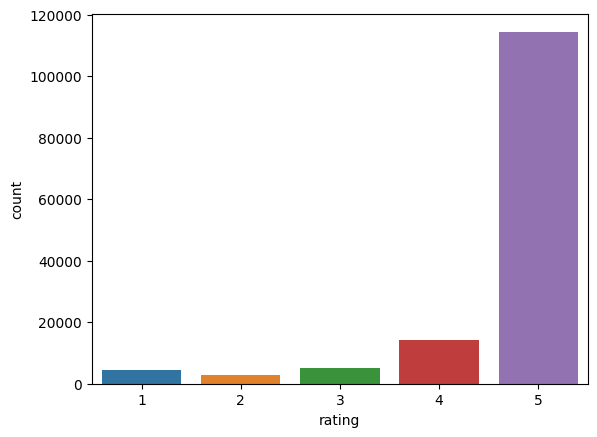

In [6]:
sns.countplot(x = df.rating)

In [7]:
df.isna().sum()

rating         0
content    38018
dtype: int64

In [9]:
df = df.dropna()
df.shape

(103263, 2)

In [10]:
X = df.content.copy()
y = df.rating.copy()
y = tf.keras.utils.to_categorical(y)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

Number of replicas: 1


In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


In [13]:
!pip install transformers

     ---------------------------------------- 7.0/7.0 MB 22.3 kB/s eta 0:00:00
     ------------------------------------- 267.9/267.9 kB 15.8 kB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 22.9 kB/s eta 0:00:00
     ------------------------------------- 151.7/151.7 kB 20.7 kB/s eta 0:00:00
     ------------------------------------- 200.1/200.1 kB 13.3 kB/s eta 0:00:00
     --------------------------------------- 77.1/77.1 kB 23.6 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 7.0/7.0 MB 21.9 kB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 24.3 kB/s eta 0:00:00
  Using cached PyYAML-6.0-cp310-cp310-win_amd64.whl (151 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached huggingface_hub-0.13.4-py3-none-any.whl (200 kB)
  Using cached regex-2023.3.23-cp310-cp310-win_amd64.whl (267 kB)



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from transformers import TFAutoModel, AutoTokenizer
MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length', 
                    truncation = True, 
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X.items()]

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ADMIN\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(inputs), 
                                                    y,
                                                    random_state=1905, 
                                                    test_size=0.2, 
                                                    shuffle=True)

In [16]:
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [17]:
# Build model
with strategy.scope():
    encoder = TFAutoModel.from_pretrained(model_name)
    
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)
    
    embedding = encoder(input_ids)[1]

    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    x = Dropout(0.2)(x)
    
    x = Dense(y.shape[1], 
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)
    
    model = Model(inputs=[input_ids], outputs = x)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRoberta  TFBaseModelOutputWithPoo  134998272
 Model)                      lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [19]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

In [20]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(X_train,
                    y_train, 
                    epochs = 20,
                    verbose = 1, 
                    validation_split = 0.1,
                    batch_size = 256)

Epoch 1/20


In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()